# 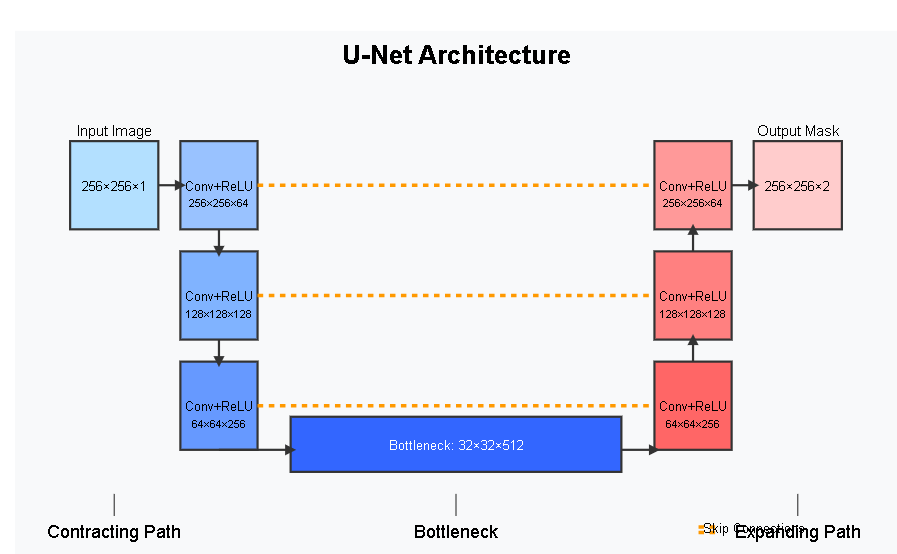

In [14]:
# from torchvision.datasets import OxfordIIITPet
# from torchvision import transforms

# dataset = OxfordIIITPet(root="F:/Python/Unet", split="trainval", target_types="segmentation", download=True, transform=transforms.ToTensor())


100%|██████████| 792M/792M [03:49<00:00, 3.45MB/s]  
100%|██████████| 19.2M/19.2M [00:05<00:00, 3.76MB/s]


In [ ]:
# !pip install torch torchvision matplotlib tqdm


Step 1: Load & Preprocess the Oxford-IIIT Pets Dataset

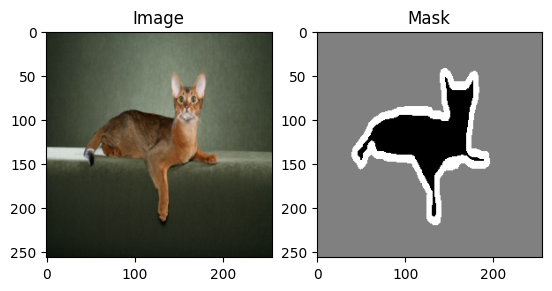

In [25]:
import torch
import torchvision
from torchvision import transforms
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define transformations for images and masks
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images
    transforms.ToTensor(),          # Convert to tensor
])
import torch
from torchvision import transforms
import torch
from torchvision import transforms

class OxfordPetsDataset(Dataset):
    def __init__(self, root, transform=None, image_size=(256, 256)):
        self.root = root
        self.transform = transform
        self.image_size = image_size  # Set a fixed image size

        self.images = sorted([f for f in os.listdir(os.path.join(root, "images")) if not f.startswith("._")])
        self.masks = sorted([f for f in os.listdir(os.path.join(root, "annotations", "trimaps")) if not f.startswith("._")])

        # Define transformations
        self.mask_transform = transforms.Compose([
            transforms.Resize(image_size),  # Resize mask
            transforms.ToTensor()
        ])

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.images[idx])
        mask_path = os.path.join(self.root, "annotations", "trimaps", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Convert mask to grayscale

        # Resize images and masks
        img = img.resize(self.image_size, Image.BILINEAR)
        mask = mask.resize(self.image_size, Image.NEAREST)  # Nearest-neighbor for masks

        if self.transform:
            img = self.transform(img)

        mask = self.mask_transform(mask)  # Convert mask to tensor

        return img, mask

    def __len__(self):
        return len(self.images)

# Load dataset
dataset = OxfordPetsDataset(root=r"F:\Python\Unet\oxford-iiit-pet", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Visualize sample
def show_sample():
    img, mask = dataset[0]  # Get the first image and mask
    fig, axs = plt.subplots(1, 2)

    axs[0].imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    axs[0].set_title("Image")

    axs[1].imshow(mask.squeeze().numpy(), cmap="gray")  # Convert mask to NumPy before displaying
    axs[1].set_title("Mask")

    plt.show()

show_sample()



Unet model

In [26]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Encoder (Contracting Path)
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder (Expanding Path)
        self.upconv4 = self.upconv(1024, 512)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = self.upconv(512, 256)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = self.upconv(256, 128)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = self.upconv(128, 64)
        self.dec1 = self.conv_block(128, 64)

        # Final output layer (1 channel for segmentation mask)
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Helper function to create a convolutional block"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        """Helper function for upsampling"""
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(F.max_pool2d(enc1, 2))
        enc3 = self.enc3(F.max_pool2d(enc2, 2))
        enc4 = self.enc4(F.max_pool2d(enc3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        # Decoder with Skip Connections
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.dec4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)

        return torch.sigmoid(self.final(dec1))  # Sigmoid for binary mask

# Instantiate model
model = UNet()


In [27]:
print(model)

UNet(
  (enc1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (bottleneck): Sequential(
    (0): Conv2d(512, 1024, k